# Lab3: Density Estimation and GMM
In this lab, you will practice the common density estimation methods including `MLE` and `MAP`. You will also learn to apply `Guassian Mixture Models` and `Expectation-Maximization` algorithm to the real nerual dataset and analyze the results.

In [62]:
using_colab = False

In [63]:
if using_colab:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/MyDrive/lab3/')

In [64]:
from scipy.io import loadmat
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from torch.distributions import Poisson
import seaborn as sns
import numpy as np
import h5py
import torch

## 1. Marginal & Conditional Probability Densities (2.5pt)

Please load the `gaussian_distribution.mat` file, which contains 2D Gaussian distribution probability density given by:

$$
p(x, y) = \frac{1}{2\pi\sqrt{|\Sigma|}} \exp\left(-\frac{1}{2} \mathbf{z}^T \Sigma^{-1} \mathbf{z}\right)
$$

Where:
- $\mathbf{z} = \begin{pmatrix} x - \mu_x \\ y - \mu_y \end{pmatrix}$ is the difference between the point $ (x, y) $ and the mean vector;
- $\Sigma$ is the covariance matrix;
- $|\Sigma|$ is the determinant of the covariance matrix;
- $\Sigma^{-1}$ is the inverse of the covariance matrix.


Then, run the following code to illustrate it. Note that the variables in the loaded data defined include:

$\quad$ `x`: a vector of $x$ points

$\quad$ `y`: a vector of $y$ points

$\quad$ `pdf`: a 2D matrix, whose $i, j$ 'th entry is the 2D Gaussian probability


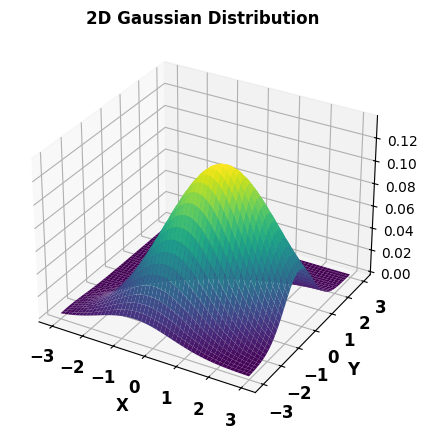

In [65]:
# read the mat format data
if using_colab:
    data = loadmat("/content/gdrive/MyDrive/lab3/data/gaussian_distribution.mat")
else:
    data = loadmat('./data/gaussian_distribution.mat')
x = data['x']
y = data['y']
pdf = data['pdf']

# plot the 2D Gaussian distribution
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, pdf, cmap='viridis', edgecolor='none')
ax.set_title("2D Gaussian Distribution", fontsize=12, fontweight='bold')
ax.set_xlabel("X", fontsize=12, fontweight='bold')
ax.set_ylabel("Y", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()


**1)** From the above joint 2D Gaussian density, we can find the marginal distribution of X by integerating the joint distribution over all possible values of Y, which is given as:

$$
p(x) = \int_{-\infty}^{\infty} p(x, y) \, dy = \int_{-\infty}^{\infty} \frac{1}{2\pi \sqrt{|\Sigma|}} \exp\left( -\frac{1}{2} \mathbf{z}^T \Sigma^{-1} \mathbf{z} \right) dy
$$
By solving this above formula, the marginal probability of X can be expressed as:
$$
p(x) = \frac{1}{\sqrt{2\pi\sigma_x^2}} \exp\left( -\frac{(x - \mu_x)^2}{2\sigma_x^2} \right)
$$

Similarly, the marginal probability of Y can be solved as:
$$
p(y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} \exp\left( -\frac{(y - \mu_y)^2}{2\sigma_y^2} \right)
$$

In practice, when we use numerical methods, the above integral process can be approximated by summing the joint probability over a range of X or Y values.  Please complete the following codes to compute the marginal probability of X (0.5pt) and Y (0.5pt) and plot them.

`Note`: The integral is not just summing these values; it's summing the "area" under the curve of $ p(x, y) $ as $ y $ varies. The area of each slice is the height of  $ p(x, y_{i}) $ multiplied by the width of the slice $ \Delta y $.

In [66]:
# P(x) - the marginal distribution over x
# step1: Obtain dy
# step2: Sum the area under the curve of 2D Gaussian distribution as y varies (np.sum)
P_X = None
# YOUR CODE HERE
dy = y[1] - y[0]
P_X = np.sum(pdf, axis=0) * dy


# P(y) - the marginal distribution over y
# step1: Obtain dx
# step2: Sum the area under the curve of 2D Gaussian distribution as x varies (np.sum)
P_Y = None
# YOUR CODE HERE
dx = x[1] - x[0]
P_Y = np.sum(pdf, axis=1) * dx

In [67]:
# TEST YOUR ANSWER
assert P_X.shape == (600, )
assert P_Y.shape == (600, )


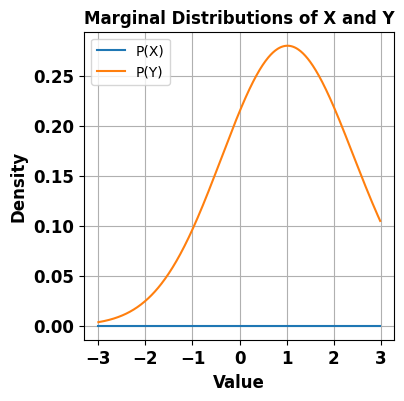

In [68]:
# plot the two marginal distribution
plt.figure(figsize=(4, 4))
plt.plot(x[:, 0], P_X, label='P(X)',)
plt.plot(y[0, :], P_Y, label='P(Y)',)
plt.xlabel('Value', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Marginal Distributions of X and Y', fontsize=12, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

**2)** The conditional probability can be computed using the joint probability density divided by the marginal probability density, which can be expressed as:

$$
P(Y | X = x) = \frac{P(X = x, Y = y)}{P(X = x)}
$$

Please calculate and plot the conditional probability $p(x|y)$ (0.5pt) and $p(y|x)$ (0.5pt) for the 2D Gaussian distribution according to the above expression.


In [69]:
# P(x|y) - the full image of the conditional density P(x|y)
P_X_Y = None
# YOUR CODE HERE
P_Y_safe = P_Y + 1e-8
P_X_Y = pdf / P_Y_safe[:, np.newaxis]

In [70]:
# TEST YOUR ANSWER
assert P_X_Y.shape == (600, 600)

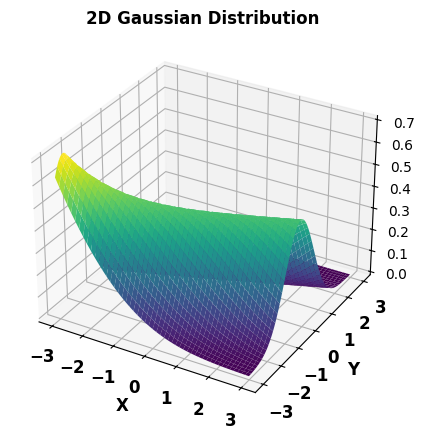

In [71]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, P_X_Y, cmap='viridis', edgecolor='none')
ax.set_title("2D Gaussian Distribution", fontsize=12, fontweight='bold')
ax.set_xlabel("X", fontsize=12, fontweight='bold')
ax.set_ylabel("Y", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

In [72]:
# P(y|x) - the full image of the conditional density P(y|x)
P_Y_X = None
# YOUR CODE HERE
P_X_safe = P_X + 1e-8
P_Y_X = pdf / P_X_safe[np.newaxis, :]

In [73]:
# TEST YOUR ANSWER
assert P_Y_X.shape == (600, 600)

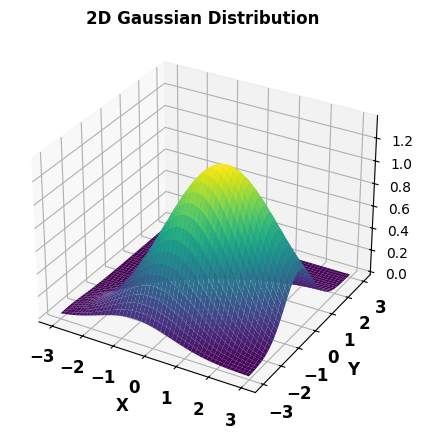

In [74]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, P_Y_X, cmap='viridis', edgecolor='none')
ax.set_title("2D Gaussian Distribution", fontsize=12, fontweight='bold')
ax.set_xlabel("X", fontsize=12, fontweight='bold')
ax.set_ylabel("Y", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

**3)** If X and Y are independent, knowing the value of X gives no information about Y, and vice versa. This can be expressed as the following formula:

$$
P(X = x, Y = y) = P(X = x)P(Y = y)
$$

Please complete the following code to see if X and Y are independent for the given 2D Gaussian distribution (0.5pt).

In [75]:
# P(y)P(x) - The independent approximation to P(x,y) (please try to use np.outer(...))
p_X_p_Y = None
# YOUR CODE HERE
p_X_p_Y = np.outer(P_Y, P_X)

In [76]:
# TEST YOUR ANSWER
assert p_X_p_Y.shape == (600, 600)

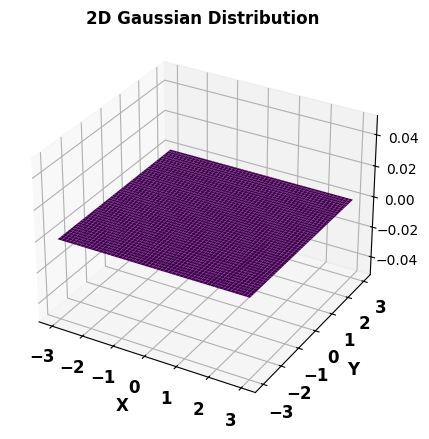

In [77]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, p_X_p_Y, cmap='viridis', edgecolor='none')
ax.set_title("2D Gaussian Distribution", fontsize=12, fontweight='bold')
ax.set_xlabel("X", fontsize=12, fontweight='bold')
ax.set_ylabel("Y", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

## 2. Maximum Likelihood Estimation (MLE) & Maximum A Posterior (MAP)

### 2.1 Maximum Likelihood Estimation (1pt)


In Lab 1, we used MLE for GLM. Here, we will start with a simpler case, using MLE to estimate a Poisson model where lambda is a free parameter not $\theta x$, On class, we have known that `Poisson distribution` is one of the simplest models of neural spike counts. Specifically, suppose $x_{t} \in \mathbb{N}_{0}$ represents the number of spikes a neuron fires in time bin $t$, and we have $x_{t} \sim Pois(\lambda)$. The pmf of poisson distribution is given by
$$
Pois(x_{t}) = \frac{\lambda^{x_{t}}e^{-\lambda}}{x_t!}
$$

Assume $\mathbf{x} = (x_{1}, x_{2}, ..., x_{T})$ denote the vector of spike counts. Then, the likelihood $p(\mathbf{x})$ can be obtained as follows:

$$
p(\mathbf{x}) = \prod_{t=1}^{T} p(x_t)
$$
$$
= \prod_{t=1}^{T} \text{Pois}(x_t)
$$
$$
= \prod_{t=1}^{T} \frac{1}{x_t!} \lambda^{x_t} e^{-\lambda}.
$$

Then, our aim is to find the rate $\lambda$ that maximizes the above likelihood, that is:
$$
\lambda_{\text{MLE}} = \arg \max p(\mathbf{x})
$$

which is the same as maximizing $log p(\mathbf{x})$. Since log is a concave function, we can simply take the derivative of $log p(\mathbf{x})$ w.r.t. $\lambda$, and set it to zero, which is shown as follows:

1) Write log likelihood:
$$
\log p(\mathbf{x}) = \sum_{t=1}^{T} -\log x_t! + x_t \log \lambda - \lambda
$$
2) Take the derivative w.r.t. $\lambda$:
$$
\frac{\text{d}}{\text{d} \lambda} \log p(\mathbf{x}) = \sum_{t=1}^{T} \left( \frac{x_t}{\lambda} - 1 \right)
$$
$$
= \frac{1}{\lambda} \left(\sum_{t=1}^{T} x_t \right) - T
$$
3) Set the derivative to zero and solve $\lambda$:
$$
\lambda_{\text{MLE}} = \frac{1}{T} \sum_{t=1}^{T} x_t
$$

According to the above results, it is easy to spot that `the MLE result of Poisson density is the mean of the empirical spike counts`. Based on this, please complete the following code to find $\lambda_{\text{MLE}}$ for the given neural spike data.


In [78]:
if using_colab:
    f = h5py.File("/content/gdrive/MyDrive/lab3/data/whitenoise.h5", mode='r')
else:
    f = h5py.File("./data/whitenoise.h5", mode='r')
frame_rate = 100
dtype = torch.float32
times = torch.tensor(f['train']['time'][:], dtype=dtype)
stimulus = torch.tensor(f['train']['stimulus'][:], dtype=torch.uint8)
spikes = torch.tensor(f['train']['response']['binned'][:].T, dtype=dtype)

# Get the size of the training data
num_frames, height, width = stimulus.shape
_, num_neurons = spikes.shape

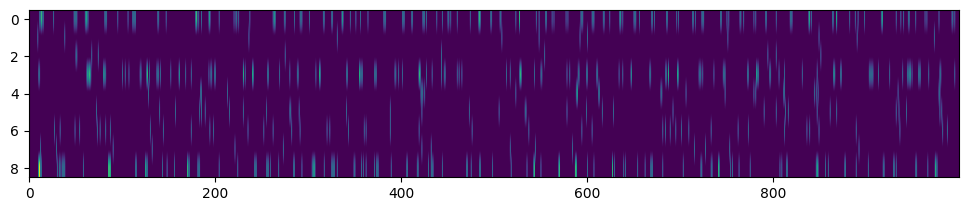

In [79]:
# Plot a few seconds of the spike train
def plot_spike_train(spikes, t_start, t_stop, figsize=(12, 6)):
    """
    `imshow` a window of the spike count matrix.

    spikes:  time x neuron spike count matrix
    t_start: time (in seconds) of the start of the window
    t_stop:  time (in seconds) of the end of the window
    figsize: width and height of the figure in inches
    """
    plt.figure(figsize=figsize)

    plt.imshow(spikes[t_start*frame_rate:t_stop*frame_rate, :].T, aspect=20)
    data = spikes[t_start*frame_rate:t_stop*frame_rate, :].T
    np.save('spike', data.numpy())

    return data

spike_data = plot_spike_train(spikes, 0, 10)

Now, let us perform MLE for the given spike count dataset by assuming it follows Possion density. Please complete the following codes:

In [80]:
# do not remove this line
np.random.seed(42)  # For reproducibility

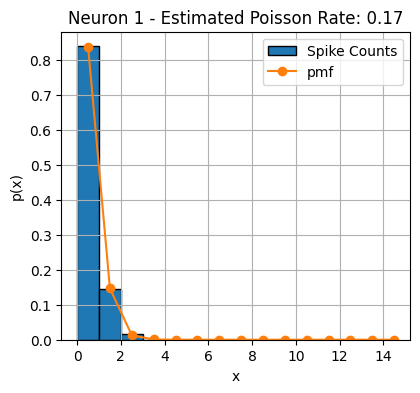

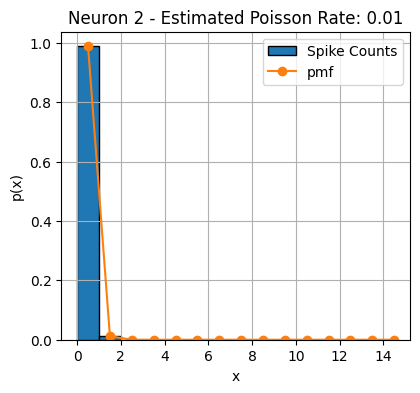

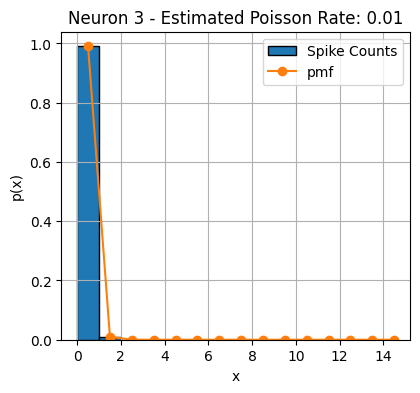

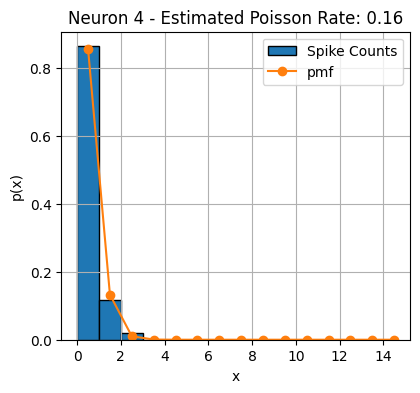

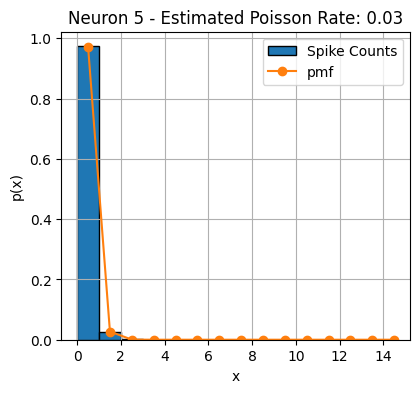

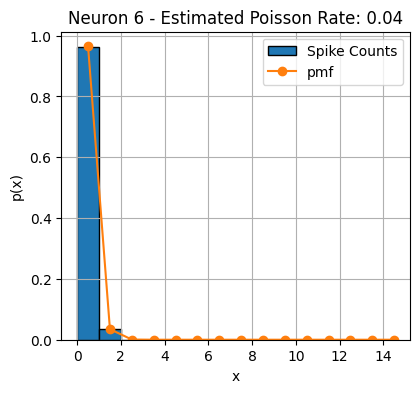

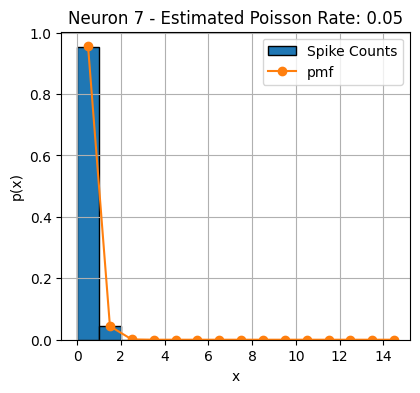

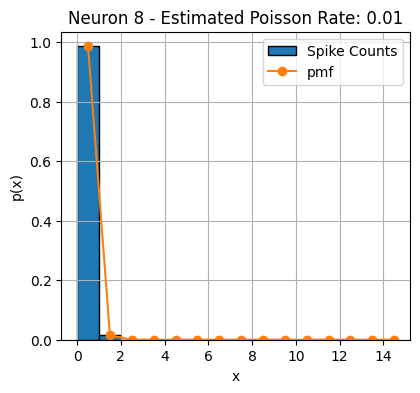

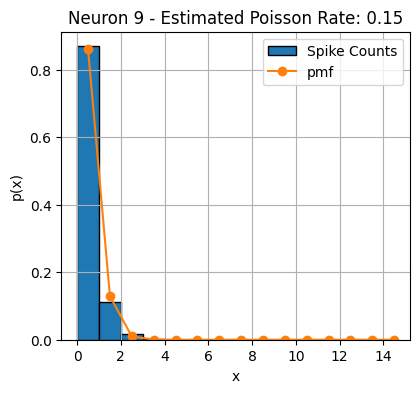

In [81]:
estimated_rates = []

# Iterate through each neuron and perform MLE
for neuron_idx in range(spike_data.shape[0]):
    estimated_lambda = None
    spike_counts = spike_data[neuron_idx].numpy()

    # hint: The MLE result of Poisson density is the mean of the empirical spike counts
    # YOUR CODE HERE
    estimated_lambda = np.mean(spike_counts)

    estimated_rates.append(estimated_lambda)

    # Plot the spike histogram and the fitted Poisson distribution
    plt.figure(figsize=(4.5, 4))
    bins = torch.arange(15)
    pois = Poisson(estimated_lambda)
    plt.hist(spike_counts, bins, density=True, edgecolor='k', label='Spike Counts')
    plt.plot(bins + .5, torch.exp(pois.log_prob(bins)), '-o', label='pmf')
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.title(f'Neuron {neuron_idx+1} - Estimated Poisson Rate: {estimated_lambda:.2f}')
    plt.grid()
    plt.legend()
    plt.show()

### 2.2 Maximum A Posterior (1pt)

The above MLE method does not take into account any prior information. If we have a sense for the distribution of neural firing rates based on our experience, we can encode this prior knowledge to the parameter estimation process, which is called MAP. For example, suppose we know that the rate $\lambda$ follows `gamma distribution`: $\lambda \sim Ga(\alpha, \beta)$, where $\alpha$ is the `shape` or `concentration` parameter, and $\beta$ is the `inverse scale` or `rate` parameter. The pdf of gamma distribution is given as:
$$
\text{Ga}(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta \lambda}
$$

where $\Gamma(\alpha)$ is the Gamma function, which generalizes the factorial function to continuous values. In a Bayesian context, when we do not know the rate $\lambda$ of Poisson distribution, we can use Gamma distribution as `conjugate prior` for $\lambda$. This means that if your prior belief about $\lambda$ is described by a Gamma distribution and you observe data modeled by a Poisson distribution, the posterior distribution of $\lambda$ (after observing the data) will also be a Gamma distribution. Now, let us consider the joint distribution of $\mathbf{x}$ and $\lambda$:
$$
p(\mathbf{x}, \lambda) = p(\mathbf{x} \mid \lambda) p(\lambda)
$$
$$
= \left[ \prod_{t=1}^{T} \text{Pois}(x_t \mid \lambda) \right] \text{Ga}(\lambda)
$$

If we want to fit the rate $\lambda$ under a gamma prior, we need to perform Bayesian inference by computing the posterior distribution of the rate $\lambda$ given the observed spike counts $\mathbf{x}$, which is given as:
$$
p(\lambda | \mathbf{x}) = \frac{p(\mathbf{x}, \lambda)}{p(\mathbf{x})}
$$

Obviously, $p(\mathbf{x})$ does not depend on $\lambda$. Therefore, we can know that $p(\lambda|\mathbf{x})$ is proportional to $p(\mathbf{x}, \lambda)$. In this case, maximizing the posterior distribution is the same as maximizing the joint distribution, that is:
$$
\lambda_{\text{MAP}} = \arg \max p(\mathbf{x}, \lambda)
$$

In this case, our aim converts to find the rate $\lambda$ that maximizes the joint distribution $p(\mathbf{x}, \lambda)$, which can be expressed as:
$$
p(\mathbf{x}, \lambda) = C \lambda^{\alpha' - 1} e^{-\beta' \lambda}
$$

where $\alpha' = \alpha + \sum_{t=1}^{T} x_t$, $\beta' = \beta + T$, and $C$ is a constant w.r.t $\lambda$. We can expand its pdf, take the log, take the derivative w.r.t. $\lambda$, set it to zero and solve it as follows:
$$
\lambda_{\text{MAP}} = \frac{\alpha' - 1}{\beta'} = \frac{\alpha - 1 + \sum_{t=1}^{T} x_t}{\beta + T}
$$

Now, let us perform MAP for the given spike count dataset by assuming that the neural firing rate follows gamma distribution. Please complete the following codes:

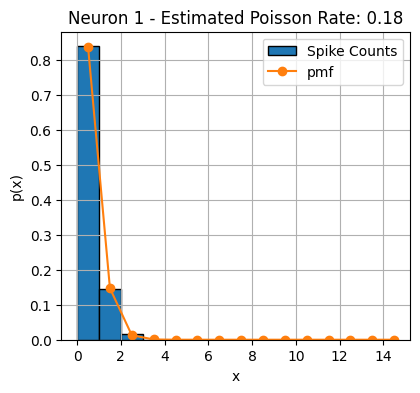

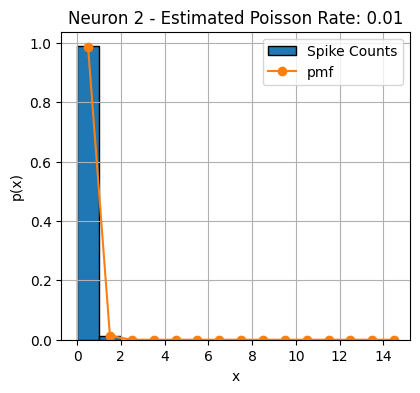

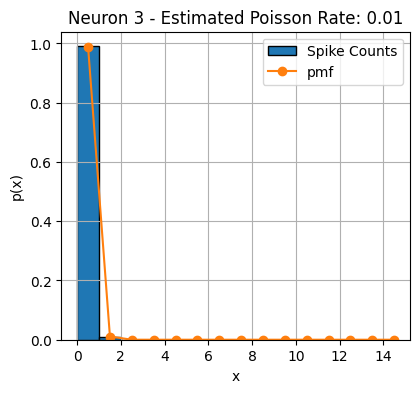

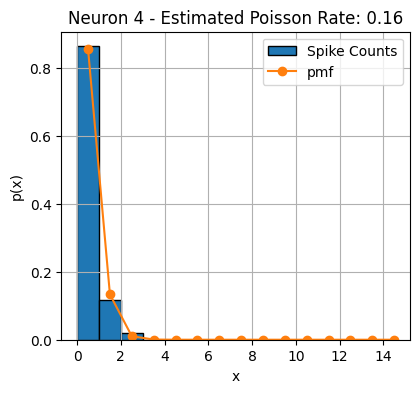

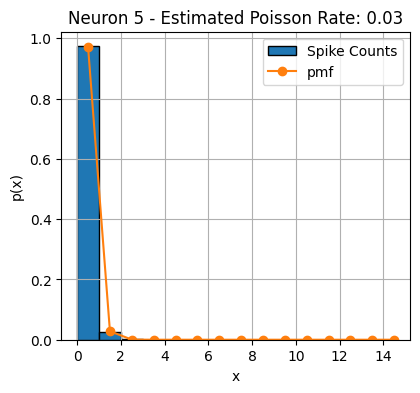

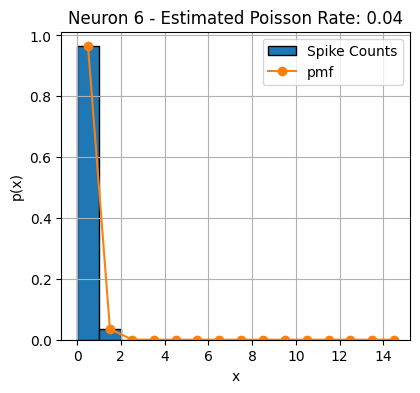

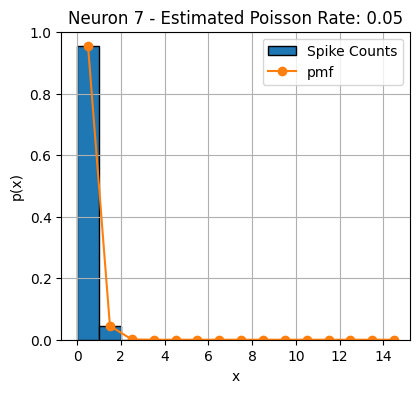

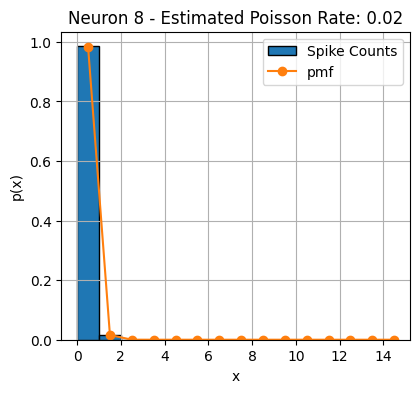

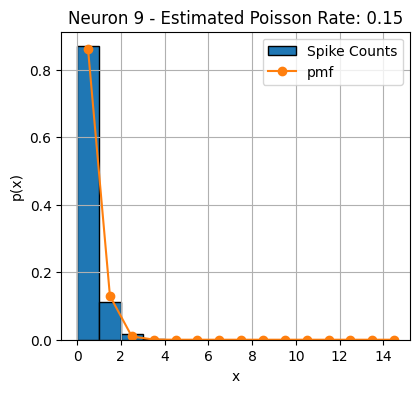

In [82]:
estimated_rates = []
alpha_prior = 2
beta_prior = 1

# Iterate through each neuron and perform MAP
for neuron_idx in range(spike_data.shape[0]):
    spike_counts = spike_data[neuron_idx].numpy()

    # Step1: compute the summation of the spike count
    # Step2: find the total number of observations
    # Step3: update the estimated lambada in terms of the given formula
    # YOUR CODE HERE
    spike_sum = np.sum(spike_counts)
    T = len(spike_counts)
    lambda_map = (alpha_prior - 1 + spike_sum) / (beta_prior + T)

    estimated_rates.append(lambda_map)

    # Plot the spike histogram and the fitted Poisson distribution
    plt.figure(figsize=(4.5, 4))
    bins = torch.arange(15)
    pois = Poisson(lambda_map)
    plt.hist(spike_counts, bins, density=True, edgecolor='k', label='Spike Counts')
    plt.plot(bins + .5, torch.exp(pois.log_prob(bins)), '-o', label='pmf')
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.title(f'Neuron {neuron_idx+1} - Estimated Poisson Rate: {lambda_map:.2f}')
    plt.grid()
    plt.legend()
    plt.show()

#### Open Question 1 (1pt):

The values of $\alpha$ and $\beta$ in the Gamma prior have a significant impact on the MAP estimation of $\lambda$. These parameters define the prior distribution, determining the extent to which prior beliefs influence the estimate relative to the observed data.

Please try two different settings of prior $\alpha$ and $\beta$ and analyze the results:

- large $\alpha$ and $\beta$ (both parameters are significantly large);
- smaller $\alpha$ and $\beta$ (both parameters are close to zero).

`Hint:` 1. Please focus more on the distribution difference between the original data and the estimated Poisson for the analysis part. 2. Using the following two cells to plot the results with different $\alpha$ and $\beta$ (you need to copy the code for MAP from previous cell).  



<span style="color:red">Your answer: Large alpha and beta values imply a strong influence from the prior, which results in a more stable but potentially biased estimate. The fitted Poisson distribution tends to be less influenced by the observed data, leading to smoother and less variable estimates compared to the original spike counts. This means the prior belief dominates, making the estimates less responsive to the actual data variability. Small alpha and beta values imply a weaker influence from the prior, allowing the observed data to play a larger role in determining the estimates. This results in estimates that are more variable and better adapted to the actual data, reflecting the true variability present in the spike counts. However, the estimates might be less stable and more prone to overfitting due to limited regularization from the prior.</span>

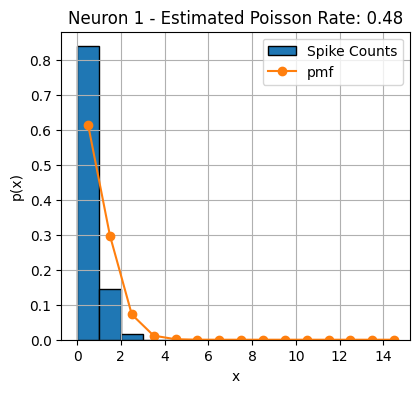

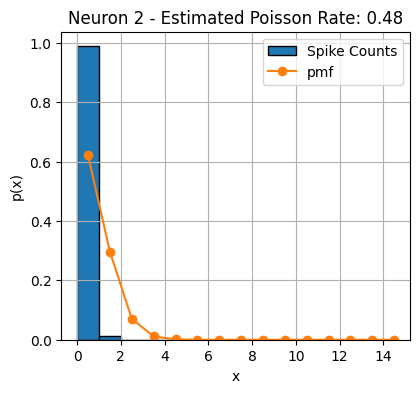

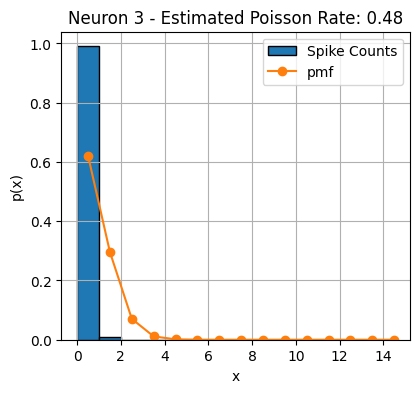

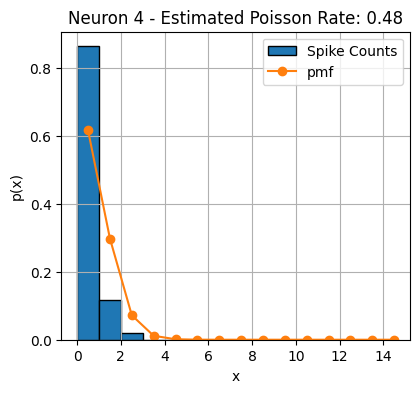

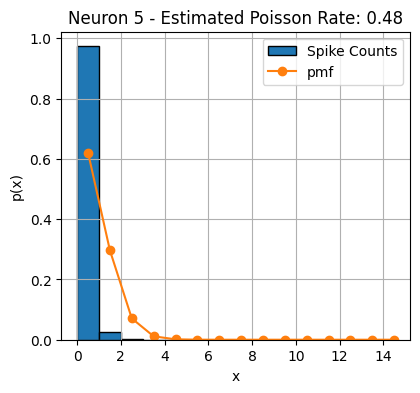

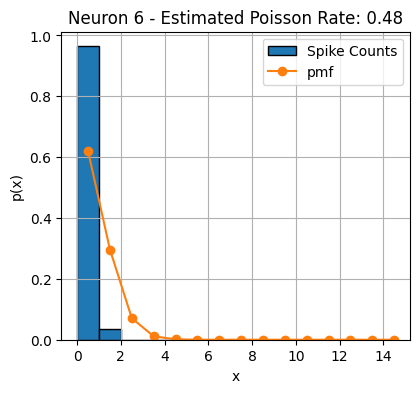

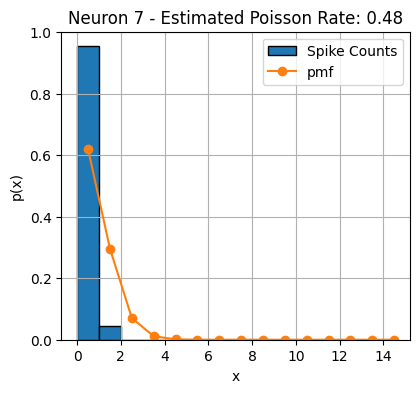

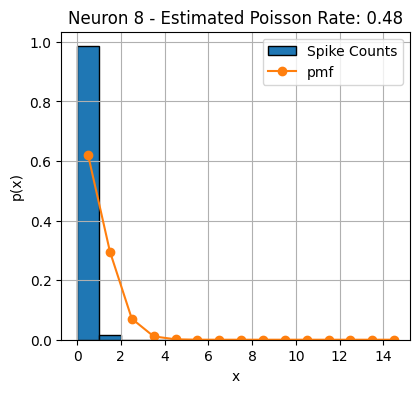

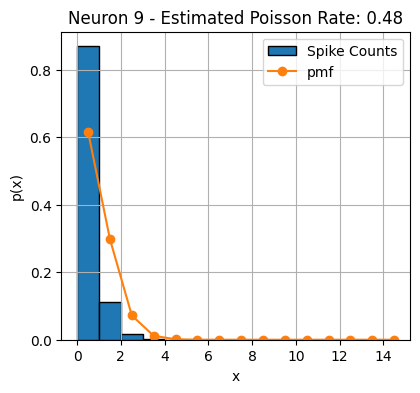

In [83]:
# Test large  𝛼  and  𝛽  (both parameters are significantly large)

estimated_rates = []

alpha_prior = None
beta_prior = None

# assign both alpha and beta with very large values
alpha_prior = 10000
beta_prior = 20000

# Iterate through each neuron and perform MAP
for neuron_idx in range(spike_data.shape[0]):
    spike_counts = spike_data[neuron_idx].numpy()

    # Step1: compute the summation of the spike count
    # Step2: find the total number of observations
    # Step3: update the estimated lambada in terms of the given formula
    # YOUR CODE HERE
    spike_sum = np.sum(spike_counts)
    T = len(spike_counts)
    lambda_map = (alpha_prior - 1 + spike_sum) / (beta_prior + T)

    estimated_rates.append(lambda_map)

    # Plot the spike histogram and the fitted Poisson distribution
    plt.figure(figsize=(4.5, 4))
    bins = torch.arange(15)
    pois = Poisson(lambda_map)
    plt.hist(spike_counts, bins, density=True, edgecolor='k', label='Spike Counts')
    plt.plot(bins + .5, torch.exp(pois.log_prob(bins)), '-o', label='pmf')
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.title(f'Neuron {neuron_idx+1} - Estimated Poisson Rate: {lambda_map:.2f}')
    plt.grid()
    plt.legend()
    plt.show()

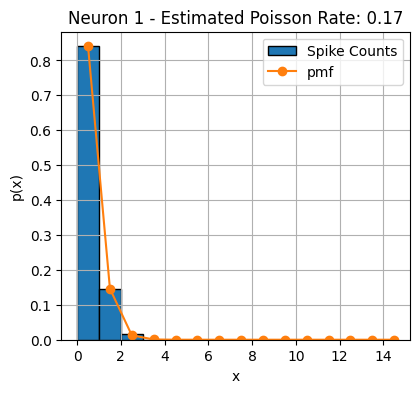

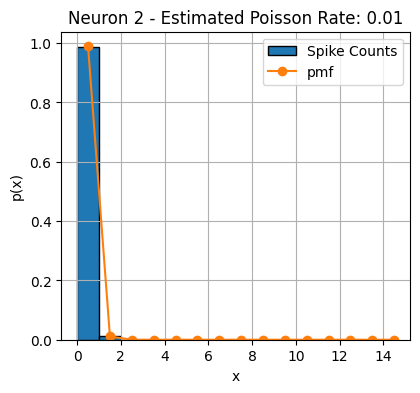

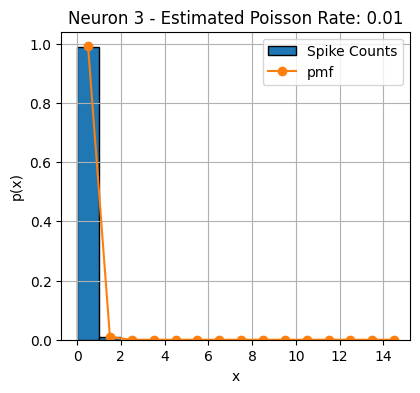

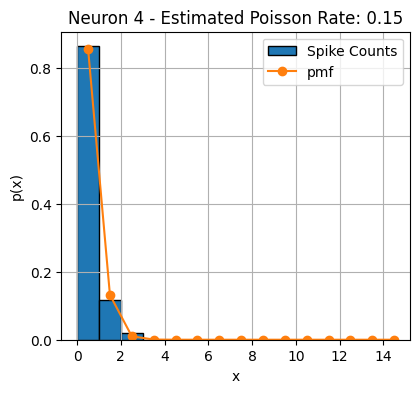

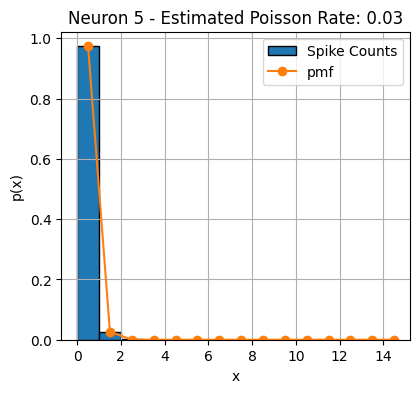

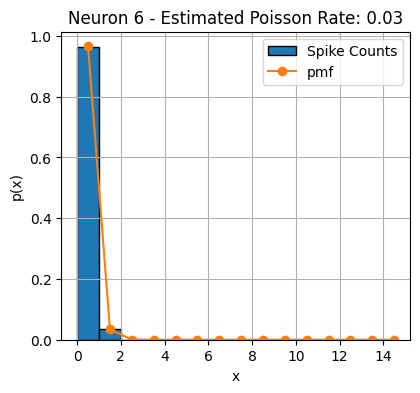

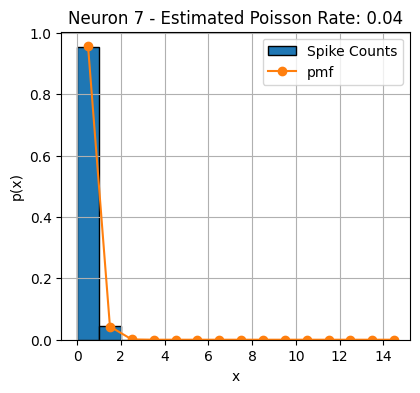

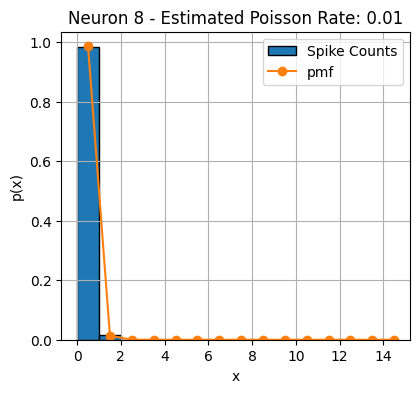

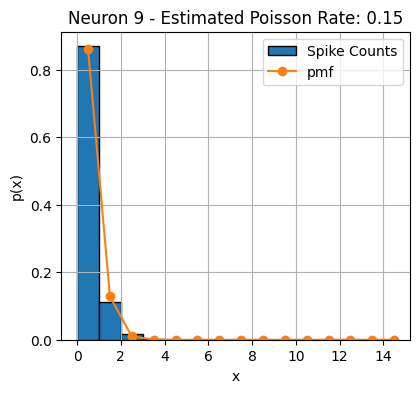

In [84]:
# Test small  𝛼  and  𝛽  (both parameters are significantly large)

estimated_rates = []

alpha_prior = None
beta_prior = None

# assign both alpha and beta with very small values (close to 0)
alpha_prior = 0.000001
beta_prior = 0.00003

# Iterate through each neuron and perform MAP
for neuron_idx in range(spike_data.shape[0]):
    spike_counts = spike_data[neuron_idx].numpy()

    # Step1: compute the summation of the spike count
    # Step2: find the total number of observations
    # Step3: update the estimated lambada in terms of the given formula
    # YOUR CODE HERE
    spike_sum = np.sum(spike_counts)
    T = len(spike_counts)
    lambda_map = (alpha_prior - 1 + spike_sum) / (beta_prior + T)

    estimated_rates.append(lambda_map)

    # Plot the spike histogram and the fitted Poisson distribution
    plt.figure(figsize=(4.5, 4))
    bins = torch.arange(15)
    pois = Poisson(lambda_map)
    plt.hist(spike_counts, bins, density=True, edgecolor='k', label='Spike Counts')
    plt.plot(bins + .5, torch.exp(pois.log_prob(bins)), '-o', label='pmf')
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.title(f'Neuron {neuron_idx+1} - Estimated Poisson Rate: {lambda_map:.2f}')
    plt.grid()
    plt.legend()
    plt.show()

## 3. Gaussian Mixture Models (GMMs) and Expectation-Maximization (EM)

### 3.1 Introduction of GMMs and EM

GMMs is a powerful tool for uncovering hidden structurs and latent patterns in complex neural data, such as spike trains or fMRI signals. it can represent different neural states or patterns as a mixture of several Gaussian distributions. For example, GMMs can be applied to cluster neural reponses or model the encoding of stimuli.

Specifically, let $\mathbf{x}_{i} \in \mathbb{R}^D$ denote the i-th observation, such as the population response or spike counts within a small time window. We use $\mathbf{z}_{i} \in \{1, \dots, K\}$ denote the discrete latent state (aka cluster assignment) of that data point. For a data point $i$, its cluster assignment $z_{i}$ is generated based on a Categorical distribution determined by the mixture weights $\pi$. The probability that data point $i$ belongs to cluster $k$ is $P(z_{i}|\pi)=\pi_{k}$. These $\pi_{k}$ values are called mixture weights. And $\sum_{k} \pi_{k} =1$, where $0 \leq \pi_{k} \leq 1 $.

Once the cluster $k$ is decided for data point $i$, we can generate the data points $x_{i}$ based on a Gaussian distribution specific to that cluster , which has a mean $\mu_{k}$ and a covariance matrix $\sum_{k}$. That is, $x_{i}|z_{i} = k \sim N(\mu_{k}, \sum_{k})$. Similarily, we want to use the MLE to find the parameters of each Gaussian distribution. By denoting the collection of all parameters to be estimated as $\theta$, the log likelihood of GMM can be denoted as:
$$
\begin{align*}
\text{log likelihood}(\theta) & = \log P(X_1, \dots, X_n = x_1, \dots, x_n | \theta) \\
& = \sum_i \log P(X_i = x_i | \theta) \\
& = \sum_i \log \sum_k P(X_i = x_i, Z_i = k | \theta)
\end{align*}
$$

We know that we cannot pass the log through the sum, making it non-trivial to directly optimize the above log likehood expression. In fact, every time when we have a latent variable, the same issue will happen. In order to address this, we introduce Expectation-Maximization (EM) method. Let us rewrite the previous log likelihood expression as:
\begin{align*}
\text{log likelihood}(\theta) & = \sum_i \log \sum_k P(X_i = x_i, Z_i = k | \theta) \\
& = \sum_i \log \sum_k P(Z_i = k | x_i, \theta) \frac{P(X_i = x_i, Z_i = k | \theta)}{P(Z_i = k | x_i, \theta)} \\
& = \sum_i \log \mathbb{E}_z \left[ \frac{P(X_i = x_i, Z_i = k | \theta)}{P(Z_i = k | x_i, \theta)} \right]
\end{align*}

According to Jensen's inequality introduced in the lecture, we can find the lower bound of the above log likelihood as:

\begin{align*}
\text{log likelihood}(\theta) & = \sum_i \log \mathbb{E}_z \left[ \frac{P(X_i = x_i, Z_i = k | \theta)}{P(Z_i = k | x_i, \theta)} \right] \\
& \geq \sum_i \mathbb{E}_z \log \left[ \frac{P(X_i = x_i, Z_i = k | \theta)}{P(Z_i = k | x_i, \theta)} \right] \quad (\text{Jensen's inequality}) \\
& = \sum_i \sum_k P(Z_i = k | x_i, \theta) \log \left[ \frac{P(X_i = x_i, Z_i = k | \theta)}{P(Z_i = k | x_i, \theta)} \right]
\end{align*}

In this case, our aim changes to maximize this lower bound so that the log likelihood can also be optimized. Let us now apply EM to GMM:

$\bullet \textbf{E-step:}$

Using Bayes Rule, we have:
\begin{align*}
P(Z_i = k | \mathbf{x_i}, \theta) &= \frac{P(\mathbf{X_i} = \mathbf{x_i} | z_i = k, \theta) P(Z_i = k | \theta)}{P(\mathbf{X_i} = \mathbf{x_i} | \theta)}
\end{align*}

In terms of the law of total probability, the denominator equals a sum over \( k \) of terms like those in the numerator. Then, we can calculate all of the terms as:.

$$
\begin{align*}
P(Z_i = k | \mathbf{x_i}, \theta) &= \frac{N(\mathbf{x_i}; \mu_{k}, \Sigma_{k}) \pi_{k}}{\sum_{k'} N(\mathbf{x_i}; \mu_{k'}, \Sigma_{k'}) \pi_{k'}} =: \gamma_{ik}.
\end{align*}
$$

$\bullet \textbf{M-step:}$

Maximizing the lower-bound:

\begin{align*}
\max_{\theta} \sum_i \sum_j \gamma_{ik} \log \frac{P(X_i = x_i, Z_i = k \mid \theta)}{\gamma_{ik}}.
\end{align*}

Because the term in the denominator does not depend on $\theta$, we can remove it from the maximization process:
\begin{align*}
\max_{\theta} \sum_i \sum_j \gamma_{ik} \log P(X_i = x_i, Z_i = k \mid \theta).
\end{align*}

For GMM, $\theta$ represents three parameters: $\pi$, $\mu$, and $\Sigma$. We can compute the updated parameters via taking the derivative w.r.t each parameter and set it 0. Then, the updated $\pi'$, $\mu'$, and $\Sigma'$ can be expressed as:

\begin{align*}
\mu_{k}' = \frac{\sum_i \mathbf{x}_i \gamma_{ik}}{\sum_i \gamma_{ik}}
\end{align*}

\begin{align*}
\Sigma_{k}' = \frac{\sum_i \gamma_{ik} (\mathbf{x}_i - \mu_{k}')(\mathbf{x}_i - \mu_{k}')^T}{\sum_i \gamma_{ik}}
\end{align*}

\begin{align*}
\mathcal{w}_{k} = \frac{\sum_i \gamma_{ik}}{n}
\end{align*}

\begin{align*}
N_{k} = \sum_i \gamma_{ik}
\end{align*}

where n is the number of total samples, and $N_{k}$ is the effective number of data points associated with component k .


### 3.2 Apply GMMs and EM on Rat hippocampal CA1 data

Now, you already know the theory of GMM and how to use EM to estimate the parameters. Let us apply GMM and EM to a public rat's hippocampus dataset: [Rat hippocampal CA1 data](https://www.nature.com/articles/s42003-023-04958-0). The Rat Hippocampal CA1 data was collected from 120 putative pyramidal neurons in the CA1 region of the hippocampus while a rat ran on a 1.6-meter linear track with rewards at both ends. Neural activity was recorded as the rat traversed the track, with one lap defined as running from one end to the other, resulting in a total of 84 laps. The `rat's position and running direction` were treated as continuous `labels` $u$, and the `recorded spike activities` were treated as the `observation` $x$, which were was binned into 25ms intervals to capture the ensemble dynamics. The illustration of the above experiment scenairo for collecting Rat Hippocampal CA1 data is shown in Figure 1.

<center><img src="https://github.com/ZKBig/8803_GMM_Lab3/blob/main/CA1_data.png?raw=true" width="600" height="200"/></center>
<!-- ![CA1_data](https://drive.google.com/uc?id=1y3QhKffqte7DbZmmXJFt2VC4zjbwrLGD) -->
<center> Figure 1: Linear track and sample running path. The two ends are labeled as L & R. Two directions are color-coded by red and blue, and positions are coded by color saturation. </center>

By inputing the spike activities to the VAE model, we obtain the latent representation of the rat's position and direction. using the latent variables instead of the raw spike activites is beneficial because VAE has already condensed the high-dimensional and complex neural activity into a more structured, interpretable latent space. In this latent space, the representations of the rat's position and direction are more separable, making it easier for us to distinguish the two directions and various positions. In this lab, we use an effective VAE model named [pi-VAE](https://arxiv.org/abs/2011.04798). `We provide the latent representation to you` sothat you can directly apply GMM and EM to identify the rat's position and direction pattern.

In [85]:
# load the latent variables
if using_colab:
    data = loadmat("/content/gdrive/MyDrive/lab3/data/CA1_latent_variables.mat")['data']
else:
    data = loadmat('./data/CA1_latent_variables.mat')['data']

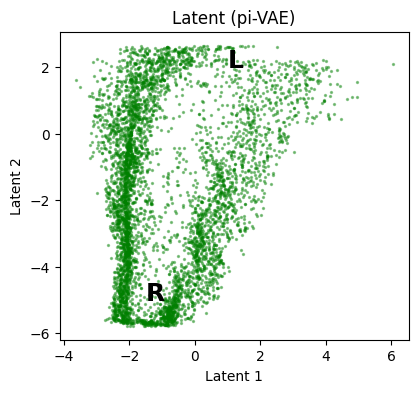

In [86]:
# Plot the latent variables
# The L and R in the figure indicates the two ends (right end and left end)
plt.figure(figsize=(4.5, 4))
plt.scatter(data[:, 0], data[:, 1], s=2, color='green', alpha=0.4)
plt.text(1, 2, 'L', fontsize=18, fontweight='bold', color='black')
plt.text(-1.5, -5, 'R', fontsize=18, fontweight='bold', color='black')
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Latent (pi-VAE)")
plt.show()

### Initialization of parameters

In [87]:
np.random.seed(42)  # For reproducibility
def multivariate_gaussian(x, mean, cov):
    return multivariate_normal.pdf(x, mean=mean, cov=cov)

In [88]:
K = 2 # number of components
n, d = data.shape # get the number of points and dimensionality

# 1. Initialize means from the data
u_s = data[np.random.choice(n, K, False)]
# 2. Initialize covariances as identity matrices
covariances = np.array([np.eye(d)] * K)
# 3. Initialize mixture weights uniformly
pi_s = np.ones(K) / K


### Run the EM process (3pt)

In [89]:
posterior = np.zeros((n, K)) # initizalize posterior probabilities
threshold = 1e-7 # set the threshold for the end of EM
max_iteration = 100 # set the maximum iteration value
prev_log_likelihood = -np.inf

for step in range(max_iteration):
    # 1. E-step:
    # 1.1 compute the posterior probabilities for each component
    # Hint for 1.1: use for-loop and multivariate_gaussian()
    # 1.2 Normalize the posterior probabilities
    # Hint for 1.2: use posterior.sum(...) to compute the summation of posterior probabilities for all components
    # The codes should be less than 5 lines
    # YOUR CODE HERE
    for k in range(K):
        posterior[:, k] = multivariate_gaussian(data, u_s[k], covariances[k]) * pi_s[k]

    posterior /= posterior.sum(axis=1)[:, np.newaxis]

    # 2. M-step:
    # 2.1 compute the effective number of data points associated with component k
    # Hint for 2.1: use posterior.sum(...)
    # This should be a one-line code
    # YOUR CODE HERE
    N_k = posterior.sum(axis=0)

    # 2.2 update means
    for k in range(K):
        u_s[k] = (posterior[:, k][:, np.newaxis] * data).sum(axis=0) / N_k[k]

    # 2.3 update covariances
    # Hint for 2.3: use for-loop and np.dot(...)
    # The codes should be less than 5 lines
    # YOUR CODE HERE
    for k in range(K):
        diff = data - u_s[k]
        covariances[k] = np.dot((posterior[:, k][:, np.newaxis] * diff).T, diff) / N_k[k]

    # 2.4 update mixture weights
    # This should be a one-line code
    # YOUR CODE HERE
    pi_s = N_k / n

    log_likelihood = 0
    for k in range(K):
        log_likelihood += np.sum(np.log(multivariate_gaussian(data, u_s[k], covariances[k])) * posterior[:, k])

    if abs(log_likelihood - prev_log_likelihood) < threshold and step > 0:
        print(f"The EM process Converges after {step} steps.")
        break

    prev_log_likelihood = log_likelihood

The EM process Converges after 66 steps.


###  Plot and analyze the resulting clusters of the rat's position and direction pattern (1.5pt)

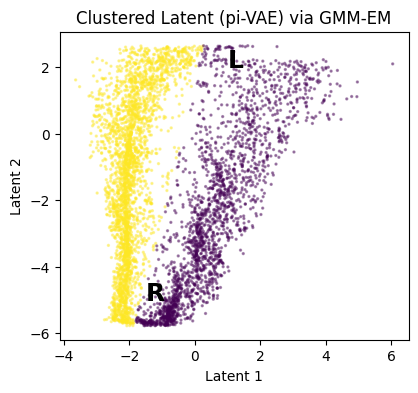

In [90]:
labels = np.argmax(posterior, axis=1)
plt.figure(figsize=(4.5, 4))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=2, alpha=0.4)
plt.text(1, 2, 'L', fontsize=18, fontweight='bold', color='black')
plt.text(-1.5, -5, 'R', fontsize=18, fontweight='bold', color='black')
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Clustered Latent (pi-VAE) via GMM-EM")
plt.show()


#### Open Question 2:
Please analyze the above clustering result via GMM and EM. For example, does the results make sense to you? what can you learn from the results?

<span style="color:red">Your answer:The clustering result in the latent space demonstrates a clear separation into two clusters, representing the left and right ends of the rat's path. The GMM-EM algorithm effectively identified these distinct behavioral states, showing that the neural activity in the hippocampus is associated with specific directional behaviors. This result supports the role of the hippocampus in encoding spatial information, with the pi-VAE effectively transforming the high-dimensional neural data into an interpretable latent space. The clustering of the latent space reveals meaningful patterns in the rat's movement, confirming the ability of GMM-EM to uncover latent structure in neural data.</span>